/home/cbu/miniconda3/envs/cms/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


visited bins: 123 | ΔE=0.1
total steps (chain tip): 70,000,000
current _m (ln f): 3.72529e-09  (target ≈ 1e-7)
stage histogram sum: 320000 | cumulative occurrences sum: 70000000
sample capture: none recorded in this block


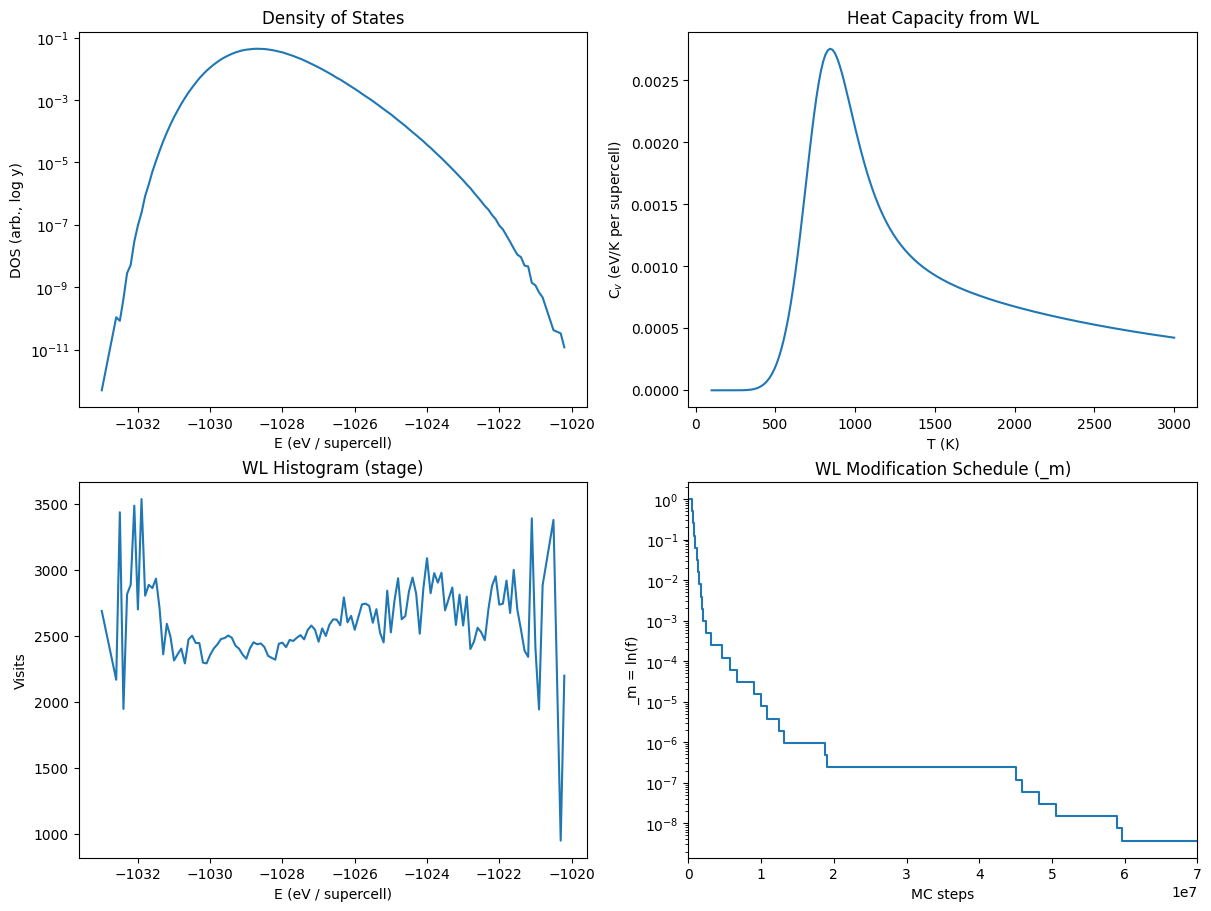

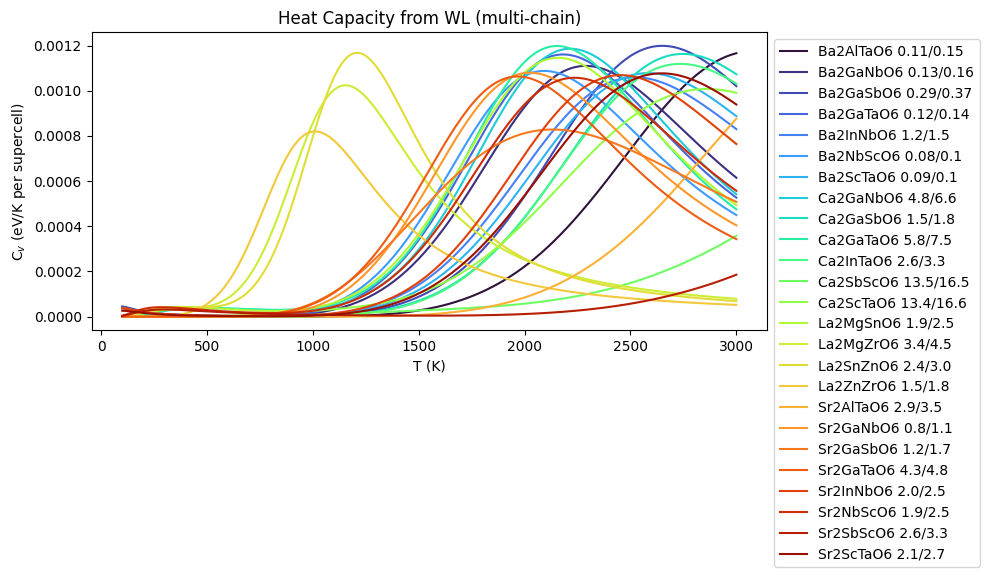

In [ ]:
from typing import Any, Mapping, TypedDict, List, Dict
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

from phaseedge.sampling.wl_block_driver import fetch_wl_tip
from phaseedge.storage.store import get_jobstore

# ----------------------------- types ---------------------------------------

class WLData(TypedDict):
    levels: np.ndarray
    entropy: np.ndarray
    histogram: np.ndarray          # stage-local (resets at flatness)
    occurrences: np.ndarray        # cumulative (never resets; may be absent in older ckpts)
    bin_indices: np.ndarray
    dE: float
    anchor: float
    m_log: float                   # current _m = ln(f)
    block: Mapping[str, Any]


# ----------------------------- loaders ------------------------------------

def load_wl_latest_from_chain(wl_key: str) -> WLData:
    block = fetch_wl_tip(wl_key)
    if not block:
        raise RuntimeError(f"No blocks found for wl_key={wl_key!r}.")
    s: Mapping[str, Any] = block["state"]

    bins: np.ndarray = np.asarray(s["bin_indices"], dtype=int)
    entropy: np.ndarray = np.asarray(s["entropy"], dtype=float)
    hist: np.ndarray = np.asarray(s["histogram"], dtype=int)
    occs_raw = s.get("occurrences", [])
    occs: np.ndarray = (
        np.asarray(occs_raw, dtype=int)
        if isinstance(occs_raw, (list, tuple))
        else np.zeros_like(hist)
    )

    anchor: float = 0.0
    dE: float = float(s["bin_size"])
    levels: np.ndarray = anchor + dE * bins.astype(float)

    order = np.argsort(bins)
    return WLData(
        levels=levels[order],
        entropy=entropy[order],
        histogram=hist[order],
        occurrences=occs[order] if occs.size else np.zeros_like(hist[order]),
        bin_indices=bins[order],
        dE=dE,
        anchor=anchor,
        m_log=float(s["mod_factor"]),  # _m = ln(f)
        block=block,
    )



def load_mod_schedule(wl_key: str, m0: float = 1.0) -> tuple[np.ndarray, np.ndarray]:
    """
    Concatenate per-block updates into a global schedule of _m (ln f),
    loading WL blocks from the Jobflow outputs store.

    Returns
    -------
    steps : np.ndarray[int]
        Monotone, starting at 0.
    m_vals : np.ndarray[float]
        Same length as steps; m at each change point.
    """
    js = get_jobstore()
    rows = list(
        js.docs_store.query(
            criteria={"output.kind": "WLBlockDoc", "output.wl_key": wl_key},
            properties={
                "_id": 0,
                "output.state.mod_factor": 1,
                "output.mod_updates": 1,
                "output.step_end": 1,
            },
            sort={"output.step_end": 1},
        )
    )
    if not rows:
        raise RuntimeError(f"No WL blocks found for wl_key={wl_key!r}.")

    # Prefer the recorded initial m from the first block, else fallback.
    first_out = rows[0].get("output", {})
    state = first_out.get("state") or {}
    m0_eff = float(state.get("mod_factor", m0))

    # Collect (step, m) updates across all blocks
    events: list[tuple[int, float]] = []
    for rec in rows:
        out = rec.get("output", {})
        for ev in out.get("mod_updates", []) or []:
            step = int(ev["step"])
            m = float(ev["m"])
            events.append((step, m))

    if events:
        # Dedup by step; keep the last m encountered for that step.
        step_to_m: dict[int, float] = {}
        for step, m in events:
            step_to_m[step] = m
        sorted_steps = sorted(step_to_m.keys())
        steps = [0] + sorted_steps
        m_vals = [m0_eff] + [step_to_m[s] for s in sorted_steps]
    else:
        tip_steps = int(rows[-1]["output"]["step_end"])
        steps = [0, tip_steps]
        m_vals = [m0_eff, m0_eff]

    return np.asarray(steps, dtype=int), np.asarray(m_vals, dtype=float)


def _extend_stair_to(steps: np.ndarray, vals: np.ndarray, right_x: int) -> tuple[np.ndarray, np.ndarray]:
    """Ensure a step curve extends horizontally to right_x."""
    if steps.size == 0:
        return np.array([0, right_x], dtype=int), np.array([1.0, 1.0], dtype=float)
    if steps[-1] < right_x:
        steps = np.append(steps, right_x)
        vals  = np.append(vals,  vals[-1])
    return steps, vals


# ----------------------------- analysis + plotting ------------------------

def analyze_wl_chain(wl_key: str) -> None:
    wl = load_wl_latest_from_chain(wl_key)
    levels  = wl["levels"]
    entropy = wl["entropy"]
    hist    = wl["histogram"]
    occ_all = wl["occurrences"]
    dE      = wl["dE"]
    steps_total = wl["block"]["step_end"]
    m_current = wl["m_log"]
    steps_m, m_vals = load_mod_schedule(wl_key)

    # DOS from entropy
    S_shift: np.ndarray = entropy - np.max(entropy) if entropy.size else entropy
    DOS: np.ndarray = np.exp(S_shift) if S_shift.size else np.array([])
    if DOS.size:
        DOS /= DOS.sum()

    # Cv(T)
    kB: float = 8.617333262e-5  # eV/K
    E:  np.ndarray = levels.astype(float)
    E_rr: np.ndarray = E - E.min() if E.size else E
    Ts: np.ndarray = np.linspace(100.0, 3000.0, 200)

    def _weights(T: float) -> np.ndarray:
        return np.exp(S_shift - E_rr / (kB * T))

    if E.size:
        Z  = np.array([_weights(T).sum() for T in Ts])
        U  = np.array([(_weights(T) * E).sum() / Z[i] for i, T in enumerate(Ts)])
        U2 = np.array([(_weights(T) * E * E).sum() / Z[i] for i, T in enumerate(Ts)])
        Cv = (U2 - U * U) / (kB * Ts * Ts)
    else:
        Z = U = U2 = Cv = np.array([])

    # ---- reporting ----
    print(f"visited bins: {levels.size} | ΔE={dE}")
    print(f"total steps (chain tip): {steps_total:,}")
    print(f"current _m (ln f): {m_current:.6g}  (target ≈ 1e-7)")
    print(f"stage histogram sum: {int(hist.sum())} | cumulative occurrences sum: {int(occ_all.sum())}")

    # ---- sample statistics (new schema: top-level fields) ----
    bin_samples = wl["block"].get("bin_samples", [])
    samples_per_bin = int(wl["block"]["samples_per_bin"])

    if bin_samples and samples_per_bin > 0:
        bins_to_occ: Dict[int, List[list[int]]] = defaultdict(list)
        for rec in bin_samples:
            try:
                b = int(rec["bin"])
                occ = rec["occ"]
            except Exception:
                continue
            bins_to_occ[b].append(occ)

        n_bins_with_samples = len(bins_to_occ)
        n_bins_full = sum(1 for occs in bins_to_occ.values() if len(occs) >= samples_per_bin)
        total_samples = sum(len(v) for v in bins_to_occ.values())
        mean_per_sampled_bin = (total_samples / n_bins_with_samples) if n_bins_with_samples else 0.0

        print(f"sample capture: {n_bins_with_samples} bins with samples")
        print(f"bins filled to quota ({samples_per_bin}): {n_bins_full}")
        print(f"total stored samples: {total_samples}  (avg {mean_per_sampled_bin:.2f} per sampled bin)")
    else:
        print("sample capture: none recorded in this block")

    # ---- plotting ----
    fig, axs = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)

    ax = axs[0, 0]
    if DOS.size:
        eps = 0.0 if np.all(DOS > 0) else 1e-300
        ax.semilogy(E, DOS + eps)
    ax.set_xlabel("E (eV / supercell)")
    ax.set_ylabel("DOS (arb., log y)")
    ax.set_title("Density of States")

    ax = axs[0, 1]
    if Cv.size:
        ax.plot(Ts, Cv)
    ax.set_xlabel("T (K)")
    ax.set_ylabel("C$_v$ (eV/K per supercell)")
    ax.set_title("Heat Capacity from WL")

    ax = axs[1, 0]
    y_visits = hist if hist.sum() > 0 else occ_all
    label = "Histogram (stage)" if y_visits is hist else "Occurrences (cumulative)"
    if y_visits.size:
        ax.plot(E, y_visits)
    ax.set_xlabel("E (eV / supercell)")
    ax.set_ylabel("Visits")
    ax.set_title(f"WL {label}")

    ax = axs[1, 1]
    right_x = max(int(steps_total), int(steps_m[-1]) if steps_m.size else 0)
    steps_m_ext, m_vals_ext = _extend_stair_to(steps_m, m_vals, right_x)
    ax.step(steps_m_ext, m_vals_ext, where="post")
    ax.set_xlim(0, right_x)
    ax.set_xlabel("MC steps")
    ax.set_ylabel("_m = ln(f)")
    ax.set_yscale('log')
    ax.set_title("WL Modification Schedule (_m)")

    plt.show()

def compute_heat_capacity_from_entropy(
    entropy: np.ndarray,
    levels: np.ndarray,
    *,
    T_min: float = 100.0,
    T_max: float = 3000.0,
    n_T: int = 200,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute heat capacity C_v(T) from WL entropy and energy levels.

    Parameters
    ----------
    entropy : np.ndarray
        Microcanonical entropy S(E) on each energy level.
    levels : np.ndarray
        Energy levels E (eV / supercell), same length as `entropy`.
    T_min, T_max : float
        Temperature range in K.
    n_T : int
        Number of temperature points.

    Returns
    -------
    Ts : np.ndarray
        Temperatures (K).
    Cv : np.ndarray
        Heat capacity (eV/K per supercell) at each T.
    """
    Ts = np.linspace(T_min, T_max, n_T)

    if entropy.size == 0 or levels.size == 0:
        return Ts, np.zeros_like(Ts)

    if entropy.shape != levels.shape:
        raise ValueError("entropy and levels must have the same shape")

    kB: float = 8.617333262e-5  # eV/K

    # Shift S so the maximum is zero (only differences in S matter)
    S_shift = entropy - np.max(entropy)

    E = levels.astype(float)
    E_rr = E - E.min()

    # Vectorized Boltzmann weights:
    # W[i, j] = exp(S_shift[i] - E_rr[i] / (kB * Ts[j]))
    beta = 1.0 / (kB * Ts)              # shape (n_T,)
    expo = S_shift[:, None] - E_rr[:, None] * beta[None, :]  # (n_levels, n_T)
    W = np.exp(expo)

    Z = W.sum(axis=0)                   # (n_T,)
    # Avoid divide-by-zero if something pathological happens
    Z[Z == 0.0] = np.finfo(float).tiny

    E_col = E[:, None]                 # (n_levels, 1)
    U = (W * E_col).sum(axis=0) / Z
    U2 = (W * (E_col * E_col)).sum(axis=0) / Z

    Cv = (U2 - U * U) / (kB * Ts * Ts)
    return Ts, Cv


def plot_heat_capacity_for_chains(
    wl_series: list[tuple[str, str]],
    *,
    T_min: float = 100.0,
    T_max: float = 3000.0,
    n_T: int = 200,
) -> None:
    """
    Plot heat capacity C_v(T) for multiple WL chains on a single axis.

    Parameters
    ----------
    wl_series : list[tuple[str, str]]
        List of (wl_key, label) pairs. `label` is used for the legend.
    T_min, T_max : float
        Temperature range in K.
    n_T : int
        Number of temperature points.
    """
    if not wl_series:
        raise ValueError("wl_series must contain at least one (wl_key, label) pair.")

    fig, ax = plt.subplots(figsize=(10, 5))
    cm = plt.get_cmap('turbo')
    ax.set_prop_cycle(color=[cm(1.*i/len(wl_series)) for i in range(len(wl_series))])
    
    for wl_key, label in wl_series:
        wl = load_wl_latest_from_chain(wl_key)
        entropy = wl["entropy"]
        levels = wl["levels"]

        Ts, Cv = compute_heat_capacity_from_entropy(
            entropy,
            levels,
            T_min=T_min,
            T_max=T_max,
            n_T=n_T,
        )

        if Cv.size == 0:
            print(f"Skipping {wl_key!r} ({label}): no entropy/levels data.")
            continue

        ax.plot(Ts, Cv, label=label)

    ax.set_xlabel("T (K)")
    ax.set_ylabel("C$_v$ (eV/K per supercell)")
    ax.set_title("Heat Capacity from WL (multi-chain)")
    
    ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
    fig.tight_layout()
    plt.show()


# ----------------------------- run ----------------------------------------

# analyze_wl_chain("3baa1e5a80cc76d13fdbd214d6784bdedc05b0a3218dd919a0088bf5895cae15") # MgAl2O4
# analyze_wl_chain("c0f51d0d2c6e2f5581b780a076b87b39efe95d2678eeb236ad5276eded3a636b") # MgGa2O4
# analyze_wl_chain("2d83ba93c4f38385b4f95136b2fbe44d74b4783c16fca136493686c5b8a693f0") # ZnAl2O4

# plot_heat_capacity_for_chains(
#     [
#         ("3baa1e5a80cc76d13fdbd214d6784bdedc05b0a3218dd919a0088bf5895cae15", "MgAl2O4"),
#         ("c0f51d0d2c6e2f5581b780a076b87b39efe95d2678eeb236ad5276eded3a636b", "MgGa2O4"),
#         ("2d83ba93c4f38385b4f95136b2fbe44d74b4783c16fca136493686c5b8a693f0", "ZnAl2O4"),
#     ]
# )


# analyze_wl_chain("f7e8773fb5d7226652dbb7a40cfd261ea1872e1a6d43693fbf1ba16ea25708f8") # Ba2AlTaO6 r2SCAN200 0.05
# analyze_wl_chain("c6a045a35a645c408868c9ab856b39a0b15a48d7cb356a1b6fa8bdc38044e8a0") # Ba2GaNbO6 r2SCAN200 0.05
# analyze_wl_chain("409264b4822e9f58c6bb8f01871561ff1defe55cb20ff65edb3422af32441a72") # Ba2GaSbO6 r2SCAN200 0.05
# analyze_wl_chain("65da00956826f98400bd13cc16274cbac22fea0cad0558a05db029bf85fe9f70") # Ba2GaTaO6 r2SCAN200 0.1
# analyze_wl_chain("081d4d2cb9b762805003103386553b335c720288ad4190e8d83ae676777ededc") # Ba2InNbO6 r2SCAN200 0.05
# analyze_wl_chain("539b833a8a763602b26e3873d9b6c034cdd823d1d321db75d2e41c364512d31f") # Ba2NbScO6 r2SCAN200 0.05
# analyze_wl_chain("79d20f7e4c4de2731296b7fd4db256c8b1ab22cd1211524f7777cf97ad89fa34") # Ba2ScTaO6 r2SCAN200 0.05
# analyze_wl_chain("e7d52be77d35970e38c81f76fb9d2187c78ad727af3d96267ffad857ecb6e34c") # Ca2GaNbO6 r2SCAN200 0.1 
# analyze_wl_chain("cfbf771a87d3130d7b9fd85fcca75f1b8dd0896d84040fedbea23053e7aec1a2") # Ca2GaSbO6 r2SCAN200 0.1 
# analyze_wl_chain("4697bdbc3e32171700e72774a95c96a315f776fa5c2436d21c38031657420e01") # Ca2GaTaO6 r2SCAN200 0.1 
# analyze_wl_chain("1d16268003a8cf1e4fbe2ff9b58384c55266f40709863ed12936fe1d32a1d11f") # Ca2InTaO6 r2SCAN200 0.1
# analyze_wl_chain("9cd8a3e28228ba6da09b562b2d7243a029e3cc66895c7c419b5e1b5a5d997562") # Ca2SbScO6 r2SCAN200 0.1 
# analyze_wl_chain("afbfb228fd8121b64862bce248d22e34b990004a040e46a94e8fec8ece67d6a7") # Ca2ScTaO6 r2SCAN200 0.1
# analyze_wl_chain("fc9f3d925700752b7727a9846be7031d3569b9220919652b3cc333f069a10217") # La2MgSnO6 r2SCAN200 0.1/0.15
# analyze_wl_chain("ece78a2efb5970098bc1fb78d882be1486ee97a848706c02e163efb9abeb07a7") # La2MgZrO6 r2SCAN200 0.05
# analyze_wl_chain("ff4787b13f0b20031aee9b760294e3d456cdb461931134a8427cfd65aa6f880b") # La2SnZnO6 r2SCAN200 0.05
# analyze_wl_chain("1c8a6503dc58a112b2a63f8188fa4c445e3f6618c12a621b12106a0db5e7914d") # La2ZnZrO6 r2SCAN200 0.05
# analyze_wl_chain("1098ba255e5995d1ce470e057f28f02e89a6209518edeebe79d3a5a7da94d144") # SrAlTaO6 r2SCAN200 0.05
# analyze_wl_chain("c44edcc8b02be3c0aab396ea27d59ef164057187561f7121cdac4aa119dc6b02") # Sr2GaNbO6 r2SCAN200 0.1
# analyze_wl_chain("2e496355b3d054a01bfdc4360a9f2d2a27ca5fa6090617b37999dc23958fb95a") # Sr2GaSbO6 r2SCAN200 0.05
# analyze_wl_chain("cc6a26e90dc6932d7f90d92e675485f75aa34a74a6d50140259594f0e1c81080") # Sr2GaTaO6 r2SCAN200 0.05
# analyze_wl_chain("f1475f18c2d33f631e859af8cb2c51c325fb49cd0366a1a2a7e5d9376339d71d") # Sr2InNbO6 r2SCAN200 0.05
# analyze_wl_chain("e9841db853b10f8c621469b5969bfede731a884c1cbfe636212df36e75d424cf") # Sr2NbScO6 r2SCAN200 0.1
# analyze_wl_chain("7c2eb46434d67bcb28cd719a5d753034aab82aa9d6b074c0b132d811ed5f5fb8") # Sr2SbScO6 r2SCAN200 0.05
# analyze_wl_chain("173c669b7c5159b5f6b838547dee22142a951af790fb5122bbebc80fb2fa8b94") # Sr2ScTaO6 r2SCAN200 0.1

plot_heat_capacity_for_chains(
    [
        ("f7e8773fb5d7226652dbb7a40cfd261ea1872e1a6d43693fbf1ba16ea25708f8", "Ba2AlTaO6 0.11/0.15"),
        ("c6a045a35a645c408868c9ab856b39a0b15a48d7cb356a1b6fa8bdc38044e8a0", "Ba2GaNbO6 0.13/0.16"),
        ("409264b4822e9f58c6bb8f01871561ff1defe55cb20ff65edb3422af32441a72", "Ba2GaSbO6 0.29/0.37"),
        ("65da00956826f98400bd13cc16274cbac22fea0cad0558a05db029bf85fe9f70", "Ba2GaTaO6 0.12/0.14"),
        ("081d4d2cb9b762805003103386553b335c720288ad4190e8d83ae676777ededc", "Ba2InNbO6 1.2/1.5"),
        ("539b833a8a763602b26e3873d9b6c034cdd823d1d321db75d2e41c364512d31f", "Ba2NbScO6 0.08/0.1"),
        ("79d20f7e4c4de2731296b7fd4db256c8b1ab22cd1211524f7777cf97ad89fa34", "Ba2ScTaO6 0.09/0.1"),
        ("e7d52be77d35970e38c81f76fb9d2187c78ad727af3d96267ffad857ecb6e34c", "Ca2GaNbO6 4.8/6.6"),
        ("cfbf771a87d3130d7b9fd85fcca75f1b8dd0896d84040fedbea23053e7aec1a2", "Ca2GaSbO6 1.5/1.8"),
        ("4697bdbc3e32171700e72774a95c96a315f776fa5c2436d21c38031657420e01", "Ca2GaTaO6 5.8/7.5"),
        ("1d16268003a8cf1e4fbe2ff9b58384c55266f40709863ed12936fe1d32a1d11f", "Ca2InTaO6 2.6/3.3"),
        ("9cd8a3e28228ba6da09b562b2d7243a029e3cc66895c7c419b5e1b5a5d997562", "Ca2SbScO6 13.5/16.5"),
        ("afbfb228fd8121b64862bce248d22e34b990004a040e46a94e8fec8ece67d6a7", "Ca2ScTaO6 13.4/16.6"),
        ("fc9f3d925700752b7727a9846be7031d3569b9220919652b3cc333f069a10217", "La2MgSnO6 1.9/2.5"),
        ("ece78a2efb5970098bc1fb78d882be1486ee97a848706c02e163efb9abeb07a7", "La2MgZrO6 3.4/4.5"),
        ("ff4787b13f0b20031aee9b760294e3d456cdb461931134a8427cfd65aa6f880b", "La2SnZnO6 2.4/3.0"),
        ("1c8a6503dc58a112b2a63f8188fa4c445e3f6618c12a621b12106a0db5e7914d", "La2ZnZrO6 1.5/1.8"),
        ("1098ba255e5995d1ce470e057f28f02e89a6209518edeebe79d3a5a7da94d144", "Sr2AlTaO6 2.9/3.5"),
        ("c44edcc8b02be3c0aab396ea27d59ef164057187561f7121cdac4aa119dc6b02", "Sr2GaNbO6 0.8/1.1"),
        ("2e496355b3d054a01bfdc4360a9f2d2a27ca5fa6090617b37999dc23958fb95a", "Sr2GaSbO6 1.2/1.7"),
        ("cc6a26e90dc6932d7f90d92e675485f75aa34a74a6d50140259594f0e1c81080", "Sr2GaTaO6 4.3/4.8"),
        ("f1475f18c2d33f631e859af8cb2c51c325fb49cd0366a1a2a7e5d9376339d71d", "Sr2InNbO6 2.0/2.5"),
        ("e9841db853b10f8c621469b5969bfede731a884c1cbfe636212df36e75d424cf", "Sr2NbScO6 1.9/2.5"),
        ("7c2eb46434d67bcb28cd719a5d753034aab82aa9d6b074c0b132d811ed5f5fb8", "Sr2SbScO6 2.6/3.3"),
        ("173c669b7c5159b5f6b838547dee22142a951af790fb5122bbebc80fb2fa8b94", "Sr2ScTaO6 2.1/2.7"),
    ]
)

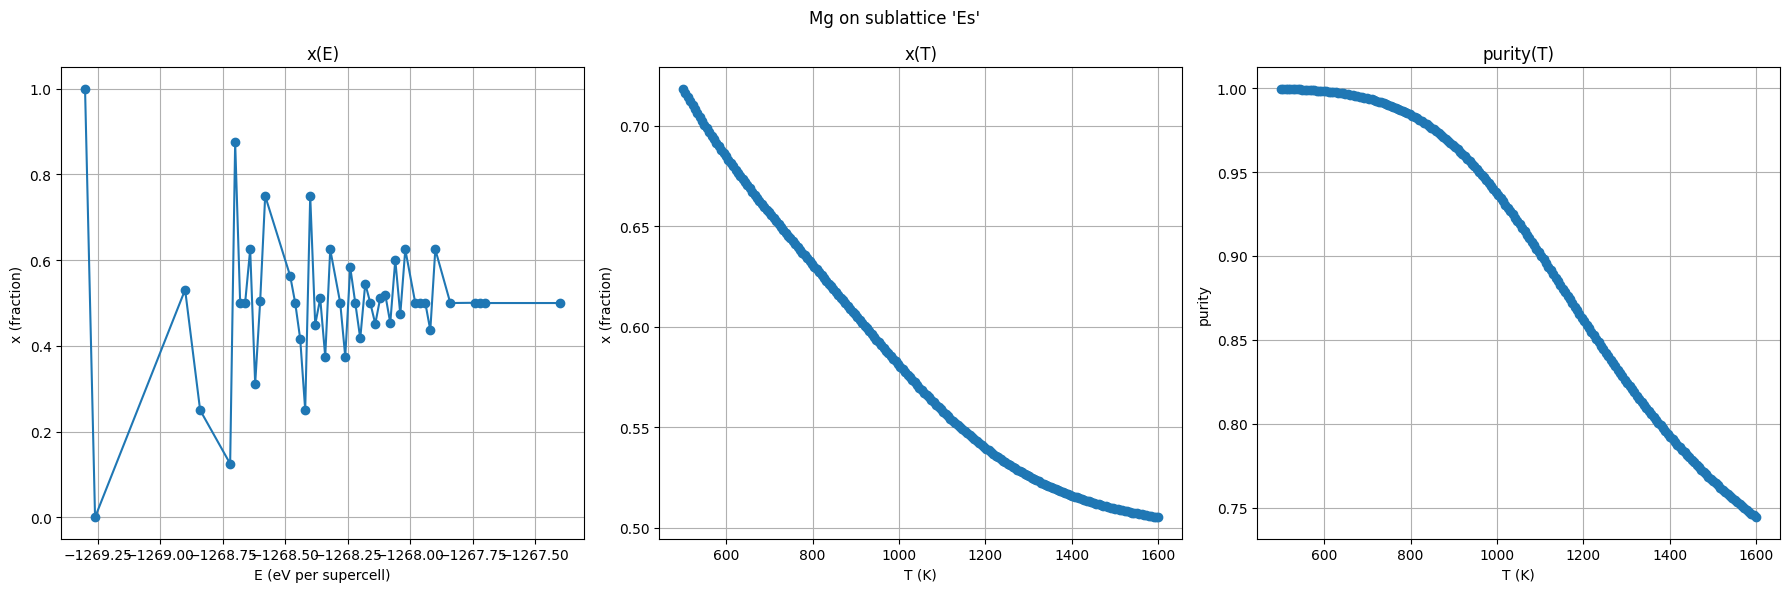

In [13]:
from typing import Any, Mapping

import math
import numpy as np
import matplotlib.pyplot as plt

from phaseedge.sampling.wl_block_driver import fetch_wl_tip


def analyze_wl_chain_tip(
    wl_key: str,
    *,
    sublattice: str,
    element: str,
    T_grid: list[float],
) -> None:
    """
    Read tip-of-chain cation composition stats and WL state for a WL key (RO connection),
    validate production mode, compute x(E), x(T), and purity(T) for a single
    (sublattice, element), and plot a single three-subplot figure:
      left   = x(E)
      middle = x(T)
      right  = purity(T).
    """
    # -------------------------
    # 1) Connect & fetch TIP
    # -------------------------
    doc = fetch_wl_tip(wl_key)
    if doc is None:
        raise ValueError(f"No blocks found for wl_key='{wl_key}'.")
    if not doc["production_mode"]:
        raise ValueError(
            f"Final WL Block for wl_key='{wl_key}' is not in production_mode. "
            "Choose a production-mode tip or resume the chain in production mode."
        )

    # -------------------------
    # 2) Extract WL state
    # -------------------------
    state = doc["state"]
    bin_indices = np.asarray(state["bin_indices"], dtype=int)
    entropy = np.asarray(state["entropy"], dtype=float)
    occurrences = np.asarray(state["occurrences"], dtype=int)
    bin_size = float(state["bin_size"])

    if not np.isfinite(bin_size) or bin_indices.size == 0 or entropy.size == 0:
        raise ValueError(
            f"Missing/incomplete WL state in block for wl_key='{wl_key}'. "
            "Require bin_indices (visited), entropy, and bin_size."
        )

    if occurrences.size != bin_indices.size:
        occ_map: dict[int, int] = {int(b): 0 for b in bin_indices.tolist()}
        n = int(min(occurrences.size, bin_indices.size))
        for i in range(n):
            occ_map[int(bin_indices[i])] = int(occurrences[i])
        occurrences = np.asarray([occ_map[int(b)] for b in bin_indices], dtype=int)

    E_map: dict[int, float] = {int(b): float(b) * bin_size for b in bin_indices.tolist()}
    S_map: dict[int, float] = {int(b): float(entropy[i]) for i, b in enumerate(bin_indices.tolist())}

    cation_agg = _aggregate_cation_counts(doc["cation_counts"])

    # x(E) and x(T)
    xE = _compute_xE(cation_agg)
    xT = _compute_xT(xE, S_map, E_map, T_grid)

    # purity(E) and purity(T)
    purityE, _sublat_sizes = _compute_purityE(cation_agg)
    purityT = _compute_purityT(purityE, S_map, E_map, T_grid)

    _plot_single_xE_xT_purity(
        sublattice=sublattice,
        element=element,
        xE=xE,
        xT=xT,
        purityT=purityT,
        E_map=E_map,
    )


def _aggregate_cation_counts(
    rows: list[dict[str, Any]]
) -> dict[int, dict[str, dict[str, dict[int, int]]]]:
    """
    Aggregate cation rows into:
      cation_agg[bin][sublattice][element_code][n_sites] = visits
    """
    agg: dict[int, dict[str, dict[str, dict[int, int]]]] = {}
    for r in rows:
        try:
            b = int(r["bin"])
            sl = str(r["sublattice"])
            elem = r["element"]
            ns = int(r["n_sites"])
            cnt = int(r["count"])
        except Exception as e:
            raise ValueError(f"Malformed cation_counts row: {r}") from e
        agg.setdefault(b, {}).setdefault(sl, {}).setdefault(elem, {})
        agg[b][sl][elem][ns] = agg[b][sl][elem].get(ns, 0) + cnt
    return agg


def _compute_xE(
    cation_agg: dict[int, dict[str, dict[str, dict[int, int]]]]
) -> dict[str, dict[str, dict[int, float]]]:
    """
    xE[sl][elem][bin] = fraction of sublattice occupied by element in that bin.

    For a fixed (bin, sl):
        Denominator D = sum_elem sum_n (n_sites * visits)
        Numerator for elem = sum_n (n_sites * visits)
        x_E = Numerator / D
    """
    xE: dict[str, dict[str, dict[int, float]]] = {}
    for b, sl_dict in cation_agg.items():
        for sl, elem_dict in sl_dict.items():
            den = 0.0
            for hist in elem_dict.values():
                for n_sites, cnt in hist.items():
                    den += float(n_sites) * float(cnt)
            if den <= 0.0:
                continue
            for elem, hist in elem_dict.items():
                num = 0.0
                for n_sites, cnt in hist.items():
                    num += float(n_sites) * float(cnt)
                frac = num / den
                xE.setdefault(sl, {}).setdefault(elem, {})[b] = float(frac)
    return xE


def _compute_purityE(
    cation_agg: dict[int, dict[str, dict[str, dict[int, int]]]],
) -> tuple[dict[str, dict[str, dict[int, float]]], dict[str, int]]:
    """
    purityE[sl][elem][bin] = average purity in that bin for that sl/elem pair,
    where purity(microstate) = max(N_elem, N_sites_total - N_elem) / N_sites_total.

    We infer N_sites_total per sublattice as the maximum n_sites observed over
    all elements / bins for that sublattice.
    """
    # First infer sublattice sizes
    sublat_sizes: dict[str, int] = {}
    for b, sl_dict in cation_agg.items():
        for sl, elem_dict in sl_dict.items():
            max_n = sublat_sizes.get(sl, 0)
            for hist in elem_dict.values():
                for n_sites in hist.keys():
                    if n_sites > max_n:
                        max_n = n_sites
            if max_n > 0:
                sublat_sizes[sl] = max_n

    purityE: dict[str, dict[str, dict[int, float]]] = {}
    for b, sl_dict in cation_agg.items():
        for sl, elem_dict in sl_dict.items():
            N_total = sublat_sizes.get(sl)
            if not N_total:
                continue
            N_total_f = float(N_total)
            for elem, hist in elem_dict.items():
                total_visits = sum(int(cnt) for cnt in hist.values())
                if total_visits <= 0:
                    continue
                purity_sum = 0.0
                for n_elem, cnt in hist.items():
                    n_elem_i = int(n_elem)
                    cnt_i = int(cnt)
                    purity = max(n_elem_i, N_total - n_elem_i) / N_total_f
                    purity_sum += purity * float(cnt_i)
                purity_avg = purity_sum / float(total_visits)
                purityE.setdefault(sl, {}).setdefault(elem, {})[int(b)] = float(purity_avg)

    return purityE, sublat_sizes


def _compute_bin_property_T(
    propE: dict[str, dict[str, dict[int, float]]],
    S_map: dict[int, float],
    E_map: dict[int, float],
    T_grid: list[float],
) -> dict[str, dict[str, dict[float, float]]]:
    """
    Generic canonical mixing:
        p_b(T) ∝ exp(S(b) - E(b)/(k_B T))
        prop_T(sl,elem; T) = sum_b p_b(T) * prop_E(sl,elem; b)
    """
    kB_eV_per_K = 8.617333262145e-5
    T_arr = np.asarray(T_grid, dtype=float)
    propT: dict[str, dict[str, dict[float, float]]] = {}

    for sl, elem_bins in propE.items():
        for elem, prop_bins in elem_bins.items():
            bins = [int(b) for b in prop_bins.keys() if int(b) in S_map and int(b) in E_map]
            if len(bins) == 0:
                continue
            bins = sorted(bins)
            S_vec = np.asarray([S_map[int(b)] for b in bins], dtype=float)
            E_vec = np.asarray([E_map[int(b)] for b in bins], dtype=float)
            prop_vec = np.asarray([prop_bins[int(b)] for b in bins], dtype=float)

            inv_kT = 1.0 / (kB_eV_per_K * T_arr.reshape(-1, 1))  # shape (T, 1)
            logw = S_vec.reshape(1, -1) - E_vec.reshape(1, -1) * inv_kT

            for ti, T in enumerate(T_arr.tolist()):
                lw = logw[ti, :]
                weights = _softmax_from_logs(lw)
                val_T = float(np.dot(weights, prop_vec))
                propT.setdefault(sl, {}).setdefault(elem, {})[float(T)] = val_T
    return propT


def _compute_xT(
    xE: dict[str, dict[str, dict[int, float]]],
    S_map: dict[int, float],
    E_map: dict[int, float],
    T_grid: list[float],
) -> dict[str, dict[str, dict[float, float]]]:
    """
    Canonical mixing of x(E) -> x(T).
    """
    return _compute_bin_property_T(xE, S_map, E_map, T_grid)


def _compute_purityT(
    purityE: dict[str, dict[str, dict[int, float]]],
    S_map: dict[int, float],
    E_map: dict[int, float],
    T_grid: list[float],
) -> dict[str, dict[str, dict[float, float]]]:
    """
    Canonical mixing of purity(E) -> purity(T).
    """
    return _compute_bin_property_T(purityE, S_map, E_map, T_grid)


def _softmax_from_logs(log_weights: np.ndarray) -> np.ndarray:
    """Stable softmax for 1D log-weights."""
    if log_weights.size == 0:
        return np.asarray([], dtype=float)
    m = float(np.max(log_weights))
    w = np.exp(log_weights - m)
    s = float(np.sum(w))
    if s == 0.0 or not math.isfinite(s):
        return np.ones_like(log_weights) / float(log_weights.size)
    return w / s


def _plot_single_xE_xT_purity(
    *,
    sublattice: str,
    element: str,
    xE: dict[str, dict[str, dict[int, float]]],
    xT: dict[str, dict[str, dict[float, float]]],
    purityT: dict[str, dict[str, dict[float, float]]],
    E_map: dict[int, float],
) -> None:
    """
    Render one figure with three subplots for the requested (sublattice, element):
      - x(E)
      - x(T)
      - purity(T)
    """
    xE_bins = xE.get(sublattice, {}).get(element, {})
    xT_series = xT.get(sublattice, {}).get(element, {})
    purityT_series = purityT.get(sublattice, {}).get(element, {})

    if len(xE_bins) == 0 and len(xT_series) == 0 and len(purityT_series) == 0:
        raise ValueError(
            f"No x(E), x(T), or purity(T) data for sublattice='{sublattice}', element={element}. "
            "Confirm the labels/codes exist in the blocks."
        )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"{element} on sublattice '{sublattice}'")

    # Left: x(E)
    ax = axes[0]
    if len(xE_bins) > 0:
        bins_sorted = sorted(xE_bins.keys())
        E_series = np.asarray([E_map[int(b)] for b in bins_sorted], dtype=float)
        y_series = np.asarray([xE_bins[int(b)] for b in bins_sorted], dtype=float)
        ax.plot(E_series, y_series, marker="o")
    ax.set_xlabel("E (eV per supercell)")
    ax.set_ylabel("x (fraction)")
    ax.set_title("x(E)")
    ax.grid(True)

    # Middle: x(T)
    ax = axes[1]
    if len(xT_series) > 0:
        Ts = sorted(xT_series.keys())
        ys = [xT_series[T] for T in Ts]
        ax.plot(np.asarray(Ts, dtype=float), np.asarray(ys, dtype=float), marker="o")
    else:
        ax.plot([], [])
    ax.set_xlabel("T (K)")
    ax.set_ylabel("x (fraction)")
    ax.set_title("x(T)")
    ax.grid(True)

    # Right: purity(T)
    ax = axes[2]
    if len(purityT_series) > 0:
        Ts = sorted(purityT_series.keys())
        ys = [purityT_series[T] for T in Ts]
        ax.plot(np.asarray(Ts, dtype=float), np.asarray(ys, dtype=float), marker="o")
    else:
        ax.plot([], [])
    ax.set_xlabel("T (K)")
    ax.set_ylabel("purity")
    ax.set_title("purity(T)")
    ax.grid(True)

    fig.tight_layout()
    plt.show()



# analyze_wl_chain_tip("79d20f7e4c4de2731296b7fd4db256c8b1ab22cd1211524f7777cf97ad89fa34", sublattice="Es", element="Ta", T_grid=np.linspace(500.0, 1600.0, 200).tolist()) # Ba2ScTaO6
# analyze_wl_chain_tip("cc6a26e90dc6932d7f90d92e675485f75aa34a74a6d50140259594f0e1c81080", sublattice="Es", element="Ta", T_grid=np.linspace(500.0, 1600.0, 200).tolist()) # Sr2GaTaO6
analyze_wl_chain_tip("6ae6403710eb2abbfbbd7000fbc811a4a9afbc37eac073470d6ba4d472e0949e", sublattice="Es", element="Mg", T_grid=np.linspace(500.0, 1600.0, 200).tolist()) # La2MgZrO6


# analyze_wl_chain_tip("3baa1e5a80cc76d13fdbd214d6784bdedc05b0a3218dd919a0088bf5895cae15", sublattice="Es", element="Al", T_grid=np.linspace(500.0, 2500.0, 200).tolist()) # MgAl2O4
# analyze_wl_chain_tip("c0f51d0d2c6e2f5581b780a076b87b39efe95d2678eeb236ad5276eded3a636b", sublattice="Es", element="Ga", T_grid=np.linspace(100.0, 2000.0, 200).tolist()) # MgGa2O4
# analyze_wl_chain_tip("2d83ba93c4f38385b4f95136b2fbe44d74b4783c16fca136493686c5b8a693f0", sublattice="Es", element="Al", T_grid=np.linspace(100.0, 2000.0, 200).tolist()) # ZnAl2O4
